In [1]:
## using Pkg
## Pkg.add("PlotlyJS")

In [9]:
using DelimitedFiles
using LinearAlgebra
using Optim
using Distributions
using Test
using BenchmarkTools
using Random
using CSV
using DataFrames
using Distributed
using Plots

In [17]:
pwd()

"/Users/FredYu/Documents/GitHub/BulkLMM.jl/analysis"

In [19]:
## Include the source code of BulkLMM to be tested:
include("../src/scan.jl");
include("../src/lmm.jl");
include("../src/wls.jl");
include("../src/util.jl");
include("../src/kinship.jl");
include("../src/readData.jl");

## Also include the helper functions for writing tests:
include("../test/testHelper.jl");

In [20]:
## Read in BXD data:
pheno_file = "../data/bxdData/BXDtraits.csv"
pheno = readBXDpheno(pheno_file);
geno_file = "../data/bxdData/BXDgeno_prob.csv"
geno = readGenoProb_ExcludeComplements(geno_file);

kinship = calcKinship(geno); # calculate kinship matrix from genotype data

In [67]:
nperms = 1024; # number of permutated copies required;
m = size(pheno, 2);
p = size(geno, 2); # number of markers

In [77]:
heritabilities = Array{Float64, 1}(undef, m);


for j in 1:m
    heritabilities[j] = scan(reshape(pheno[:, j], :, 1), geno, kinship; reml = true)[2] 
end

LoadError: InterruptException:

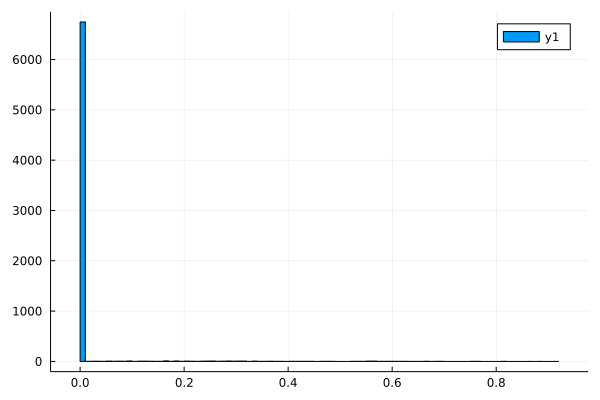

In [88]:
histogram(heritabilities[1:7000], bins = 100)

In [87]:
length(heritabilities)

7321

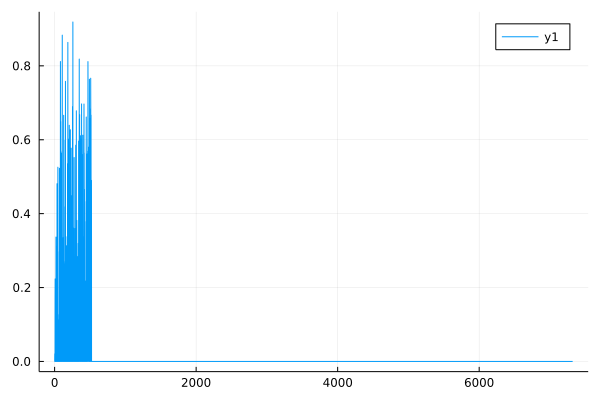

In [80]:
plot(heritabilities)

In [81]:
findmax(heritabilities)

(0.9187157734609227, 258)

In [89]:
## Consider the 7919-th trait
pheno_y = reshape(pheno[:, 7919], :, 1);

In [94]:
include("../src/scan.jl");

In [95]:
@btime scan_perms(pheno_y, geno, kinship; nperms = 100);

  1.386 s (183989 allocations: 1.37 GiB)


In [91]:
@btime scan_perms(pheno_y, geno, kinship; nperms = 1024); # output structures of function

  1.400 s (183990 allocations: 1.37 GiB)


In [96]:
results_nperms = scan_perms(pheno_y, geno, kinship); # output structures of function

In [97]:
size(results_nperms)

(1025, 7321)

## Do the same for many traits (first 1000):

In [108]:
# Function that extracts the row maximums for a matrix:
function getMaxLod_manyTraits(pheno::Array{Float64, 2}, geno::Array{Float64, 2}, kinship::Array{Float64, 2};
                              ntraits::Int64 = 1000, nperms::Int64 = 1024, original::Bool = true)
    
    if original
        nrows = nperms+1
    else
        nrows = nperms
    end
    
    maxLods_manyTraits = Matrix{Float64}(undef, nrows, ntraits);
    
    for k in 1:ntraits
        
        pheno_k = reshape(pheno[:, k], :, 1);
        results = scan_perms(pheno_k, geno, kinship; nperms = nperms)
        
        maxLods_manyTraits[:, k] = getMaxLod(results)
    end
    
    return maxLods_manyTraits; 
end


function getMaxLod(results::Array{Float64, 2})
    
    return mapslices(x -> maximum(x), results; dims = 2);
    
end

getMaxLod (generic function with 1 method)

In [44]:
maxLods = getMaxLod(results_nperms);

In [104]:
typeof(maxLods)

Matrix{Float64} (alias for Array{Float64, 2})

In [103]:
size(maxLods)

(1025, 1)

In [105]:
quantile(maxLods[:, 1], 0.95)

3.75008800449138

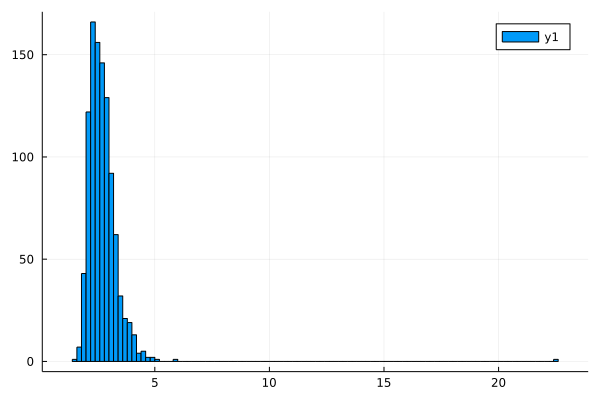

In [45]:
histogram(maxLods)

In [ ]:
@btime getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 1000, nperms = 100)

In [130]:
maxLods_1000Traits = getMaxLod_manyTraits(pheno, geno, kinship; ntraits = 1000, nperms = 100);

In [136]:
size(maxLods_1000Traits)

(101, 1000)

In [137]:
quantile_1000Traits = mapslices(x -> quantile(x, 0.95), maxLods_1000Traits; dims = 1)

1×1000 Matrix{Float64}:
 3.80872  3.42753  3.70595  3.47996  …  3.44377  3.69514  3.37991  3.92362

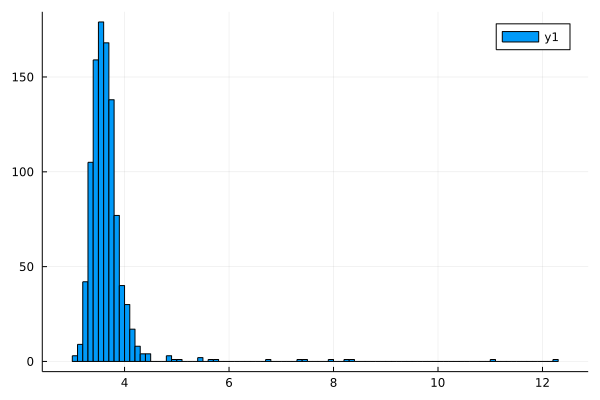

In [142]:
histogram(vec(quantile_1000Traits), bins = 100)